<a href="https://colab.research.google.com/github/ShikhaVishwakarma/EagleView-DL-ML-Assignment-for-Data-Scientist/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting started


In [37]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.densenet import preprocess_input

In [4]:
from google.colab import files

import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
image_dir=Path('/content/gdrive/MyDrive/CarPerson')

#Create file dataframe


In [7]:
filepaths=list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
1,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
2,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
3,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
4,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
...,...,...
2234,/content/gdrive/MyDrive/CarPerson/Car/image_00...,Car
2235,/content/gdrive/MyDrive/CarPerson/Car/image_00...,Car
2236,/content/gdrive/MyDrive/CarPerson/Car/image_00...,Car
2237,/content/gdrive/MyDrive/CarPerson/Car/image_00...,Car


In [8]:
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

#Load image data

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 1433 validated image filenames belonging to 2 classes.
Found 358 validated image filenames belonging to 2 classes.
Found 448 validated image filenames belonging to 2 classes.


#Training


In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
45/45 [==============================] - 52s 1s/step - loss: 0.6951 - accuracy: 0.4857 - val_loss: 0.6927 - val_accuracy: 0.5112 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 49s 1s/step - loss: 0.6937 - accuracy: 0.4794 - val_loss: 0.6932 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 49s 1s/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4888 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 48s 1s/step - loss: 0.6933 - accuracy: 0.4829 - val_loss: 0.6931 - val_accuracy: 0.5196 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 49s 1s/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5475 - lr: 1.0000e-04
Epoch 6/100
45/45 [==============================] - 48s 1s/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.5223 - lr: 1.0000e-04


In [12]:
train_images.class_indices

{'Car': 0, 'Person': 1}

#Results

In [26]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.69325
Test Accuracy: 50.67%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


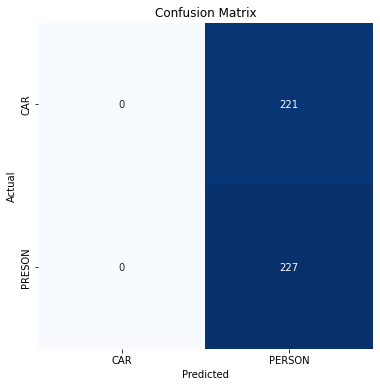

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAR       0.00      0.00      0.00       221
      PERSON       0.51      1.00      0.67       227

    accuracy                           0.51       448
   macro avg       0.25      0.50      0.34       448
weighted avg       0.26      0.51      0.34       448



In [27]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAR", "PERSON"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAR", "PERSON"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAR", "PRESON"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

#Prediction on a new image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image is of a car.


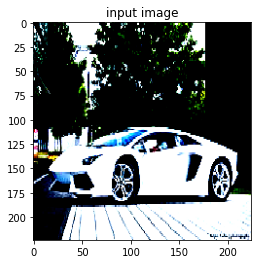

In [39]:
#Path to the image to see if the model predicts the correct class
path="/content/48a7eaf8914ce196bd77acacfb58b262.jpg"
img=load_img(path,target_size=(224,224))

i=img_to_array(img)


i=preprocess_input(i)

input_arr=np.array([i])
input_arr.shape

pred=np.argmax(model.predict(input_arr))

if pred==0:
  print('The image is of a car.')
else:
  print('The image is of a person.')

#To display an image
plt.imshow(input_arr[0])
plt.title('input image')
plt.show()